In [1]:
import xarray as xr
import random
from joblib import load, dump
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import pandas as pd

In [2]:
sea_str = np.genfromtxt('/home/users/jowanf/RF_ranking_sea.txt',dtype=str,delimiter='\t')
land_str = np.genfromtxt('/home/users/jowanf/RF_ranking_land.txt',dtype=str,delimiter='\t')

In [3]:
def ranking_extract(str_gen,channel_num=8):
    hold = np.zeros((len(str_gen),8),dtype=int)
    num_hold = np.zeros(len(str_gen),dtype=int)
    for i in range(len(str_gen)):
        screen = np.loadtxt([str_gen[i],str_gen[i]],dtype=str,delimiter=',')[0][0].split()
        num_hold[i] = np.loadtxt([str_gen[i],str_gen[i]],dtype=str)[0][-4]
        formated_screen = screen[-channel_num:]
        for j in range(channel_num):
            if j == 0:
                hold[i][channel_num-1] = formated_screen[-1][:-1]
            if (j >= 1) and (j < channel_num-1):
                hold[i][-j-1] = formated_screen[-j-1]
            if j == channel_num-1:
                if formated_screen[0][0] =='[':
                    hold[i][0] = formated_screen[0][1:]
                else:
                    hold[i][0] = formated_screen[0]
    reorder = np.zeros((np.shape(hold)),dtype=int)
    for i in range(np.shape(reorder)[0]):
        dim0_index = num_hold[i]-1
        for j in range(np.shape(reorder)[1]):
            reorder[dim0_index][j] = hold[i][j]                
    return reorder, np.arange(1,len(str_gen)+1)

In [4]:
#find the percentage of 1s in each channel
channel_num = 8
sea_ranking, sea_number = ranking_extract(sea_str)
land_ranking, land_number = ranking_extract(land_str)
sea_portion = np.divide(sea_ranking,np.transpose([sea_number for x in range(channel_num)]))
land_portion = np.divide(land_ranking,np.transpose([land_number for x in range(channel_num)]))

In [5]:
def stacker_plot(plot_mat,plot_vec,title='',ylabel='number in each channel',xlabel='number of features'):
    # Create data
    x=plot_vec
    y1=plot_mat[:,0]
    y2=plot_mat[:,1]
    y3=plot_mat[:,2]
    y4=plot_mat[:,3]
    y5=plot_mat[:,4]
    y6=plot_mat[:,5]
    y7=plot_mat[:,6]
    y8=plot_mat[:,7]
    # Basic stacked area chart.
    plt.stackplot(x,y1, y2, y3,y4, y5, y6,y7, y8, labels=['ch1','ch2','ch3','ch4','ch5','ch6','ch7','ch8'])
    plt.legend(loc='upper left')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    #not good at displaying the important features

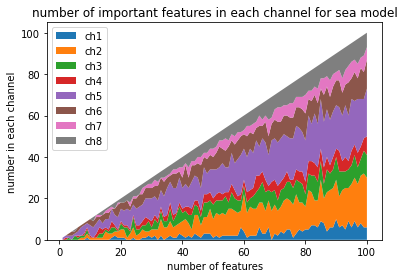

In [6]:
stacker_plot(sea_ranking,sea_number,'number of important features in each channel for sea model')

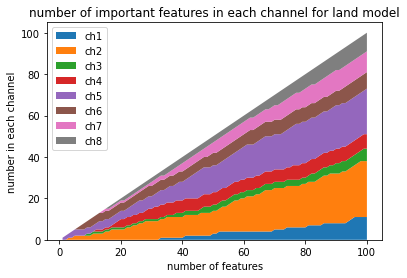

In [7]:
stacker_plot(land_ranking,land_number,'number of important features in each channel for land model')

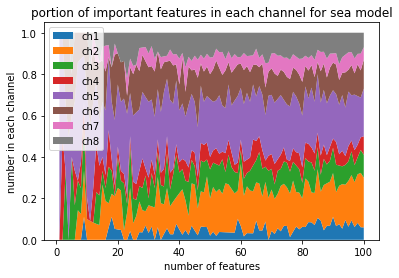

In [8]:
stacker_plot(sea_portion,sea_number,'portion of important features in each channel for sea model')

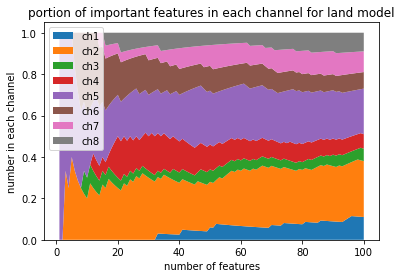

In [9]:
stacker_plot(land_portion,land_number,'portion of important features in each channel for land model')

In [25]:
def rank_data(seq,method='max',channel_num=8): 
    channel_ranking = np.zeros(np.shape(seq))
    for i in range(np.shape(channel_ranking)[0]):
        ranked = channel_num + 1 - ss.rankdata(seq[i],method=method)
        for j in range(len(ranked)):
            channel_ranking[i][j] = ranked[j]
    return channel_ranking

In [27]:
sea_ranked = rank_data(sea_ranking,'ordinal')
land_ranked = rank_data(land_ranking,'ordinal')

In [32]:
channel_num = 8
num_ones = [np.ceil((x+1)/channel_num) for x in range(np.size(sea_ranked))]
channel = [x%channel_num + 1 for x in range(np.size(sea_ranked))]
sea_rank = np.reshape(sea_ranked,-1)
land_rank = np.reshape(land_ranked,-1)
extent = 8*12

In [33]:
diction = {'num ones':num_ones[:extent],'channel':channel[:extent],'sea rank':sea_rank[:extent],'land rank':land_rank[:extent]}
data = pd.DataFrame(data=diction)

In [49]:
def bump_plot(data,domain,n_top_ranked=8):
    plotted_data = domain + ' rank'
    top_sources = data[data["num ones"] == data["num ones"].max()].nsmallest(n_top_ranked, plotted_data)
    fig, ax = plt.subplots(figsize=(12, 7), subplot_kw=dict(ylim=(0.5, 0.5 + n_top_ranked)))

    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_major_locator(MultipleLocator(1))

    yax2 = ax.secondary_yaxis("right")
    yax2.yaxis.set_major_locator(FixedLocator(top_sources[plotted_data].to_list()))
    yax2.yaxis.set_major_formatter(FixedFormatter(top_sources["channel"].to_list()))

    for i, j in data.groupby("channel"):
        ax.plot("num ones", plotted_data, "o-", data=j, mfc="w",linewidth=4)

    ax.invert_yaxis()
    ax.set(xlabel="number of ones", ylabel="Rank", title= domain + ' model channel rank with number of ones')
    ax.grid(axis="x")
    plt.tight_layout()

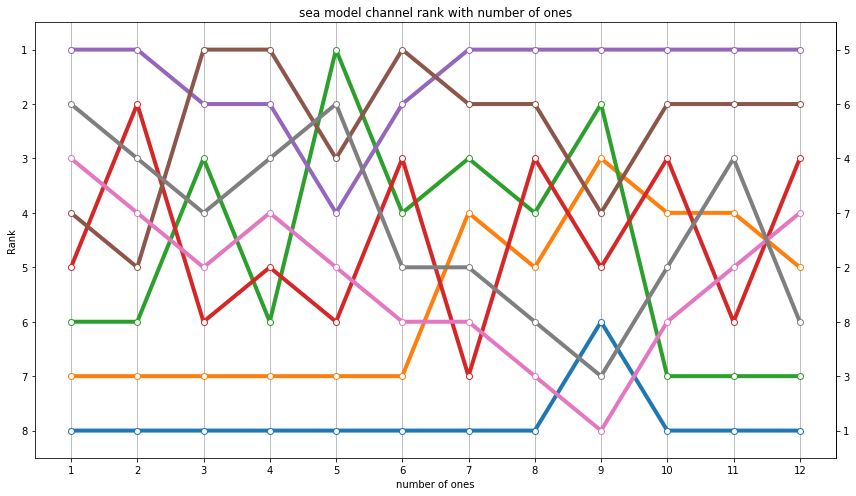

In [50]:
bump_plot(data,'sea')

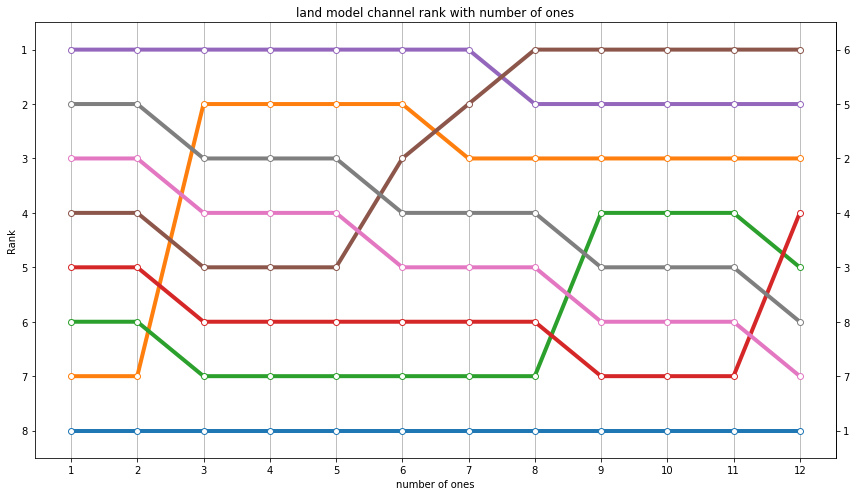

In [51]:
bump_plot(data,'land')